In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import math
from datetime import date
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option("display.max_rows", 100, "display.max_columns", 100)
# pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

def p(s):
    print(s)
    
pd.DataFrame.len = pd.Index.len = lambda x: print(len(x))

In [2]:
# Common function definitions
def printStats(y_dev, y_pred):
    # Graph
    plt.scatter(y_dev, y_pred)
    plt.plot(y_pred,y_pred,color='black')
    plt.show()
    
    # Stats
    mae = mean_absolute_error(y_dev, y_pred).round(1)
    rmse = round(math.sqrt(mean_squared_error(y_dev, y_pred)),1)
    r2 = r2_score(y_dev, y_pred).round(2)
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'R^2: {r2}')
    
def cvGrid(params):
    names = ['param_' + x for x in list(params.keys())]
    return pd.DataFrame(grid.cv_results_)[names+['mean_test_score','std_test_score','rank_test_score','mean_fit_time','mean_score_time','std_fit_time','std_score_time']].sort_values(names)


In [4]:
# Partition training, dev, and test data
seasonHist = pd.read_csv('../seasonHist.csv')
X = seasonHist \
    .loc[:,seasonHist.columns.str.contains('-\d+') | seasonHist.columns.str.match('fanPts')] \
    .drop('fanPts',axis=1) \
    .fillna(0)
y = seasonHist.fanPts

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_dev_raw, X_test_raw, y_dev, y_test = train_test_split(X_test_raw, y_test, test_size=0.5, random_state=0)

# Scale
ss = preprocessing.StandardScaler()
X_train_std = pd.DataFrame(ss.fit_transform(X_train_raw), columns=X_train_raw.columns)
X_dev_std = pd.DataFrame(ss.fit_transform(X_dev_raw), columns=X_dev_raw.columns)
X_test_std = pd.DataFrame(ss.fit_transform(X_test_raw), columns=X_test_raw.columns)

# Manually downselect useful columns
keepCols = \
    X.columns.str.contains('fanPts') | \
    X.columns.str.contains('^complete_pass') | \
    X.columns.str.contains('rush_attempt') | \
    X.columns.str.contains('yards_gained') | \
    X.columns.str.contains('^touchdown')

X_train_select, X_dev_select, X_test_select = X_train_raw.loc[:,keepCols], X_dev_raw.loc[:,keepCols], X_test_raw.loc[:,keepCols]
X_train_std_select, X_dev_std_select, X_test_std_select = X_train_std.loc[:,keepCols], X_dev_std.loc[:,keepCols], X_test_std.loc[:,keepCols]

### Linear Regression

#### Base model

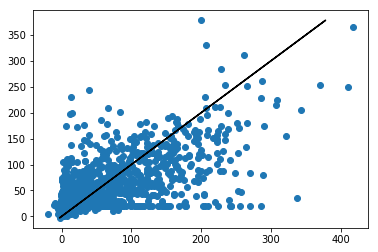

MAE: 31.7
RMSE: 47.4
R^2: 0.45


,touchdown-1,fumble-1,fanPts-1,yards_gained-1,rec_yards-1,rush_yards-1,rush_yards-3,rec_yards-3,yards_gained-3,pass_touchdown-3,yards_gained-2,rush_yards-2,rec_yards-2,rush_touchdown-3,rush_touchdown-2,pass_touchdown-2,interception-2,complete_pass-2,pass_attempt-2,incomplete_pass-2,incomplete_pass-1,fumble-2,complete_pass-1,complete_pass-3,pass_attempt-3,fumble-3,incomplete_pass-3,pass_attempt-1,interception-1,interception-3,rush_touchdown-1,fanPts-3,touchdown-2,pass_touchdown-1,touchdown-3,qb_hit-2,fanPts-2,qb_dropback-1,qb_hit-1,tackled_for_loss-1,rush_attempt-1,qb_hit-3,qb_dropback-3,tackled_for_loss-3,rush_attempt-3,no_huddle-1,qb_dropback-2,shotgun-1,no_huddle-3,shotgun-3,tackled_for_loss-2,no_huddle-2,yards_after_catch-1,rush_attempt-2,shotgun-2,yards_after_catch-2,air_yards-2,yards_after_catch-3,air_yards-3,air_yards-1
1,-63963482571.977,21321160856.250,10660580428.686,-1066058030.825,-11.962,-11.902,9.725,9.705,-9.575,7.765,6.992,-6.920,-6.892,6.533,5.209,4.729,4.477,3.764,-3.742,3.313,2.630,-2.427,2.299,-2.256,2.210,-1.972,-1.969,-1.961,1.781,-1.304,1.133,-1.073,-1.024,0.994,-0.676,-0.610,-0.593,-0.481,-0.473,0.469,-0.323,0.262,-0.256,0.184,-0.153,-0.106,-0.081,0.057,0.057,-0.052,-0.023,-0.018,-0.015,0.014,0.013,0.009,0.008,0.008,-0.007,0.003


In [4]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

m = linear_model.LinearRegression()
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()

### Ridge Regression

#### Base model

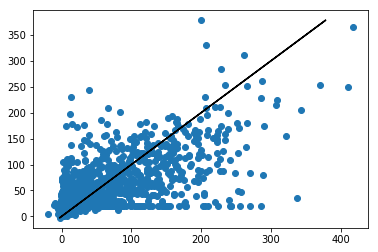

MAE: 31.7
RMSE: 47.4
R^2: 0.45


,rush_yards-3,rec_yards-3,yards_gained-3,pass_touchdown-3,yards_gained-1,rec_yards-1,rush_yards-1,rush_touchdown-3,yards_gained-2,rush_yards-2,rec_yards-2,rush_touchdown-2,pass_touchdown-2,interception-2,complete_pass-2,pass_attempt-2,incomplete_pass-2,incomplete_pass-1,fumble-2,complete_pass-1,complete_pass-3,pass_attempt-3,fumble-3,pass_attempt-1,incomplete_pass-3,interception-1,interception-3,rush_touchdown-1,fanPts-3,touchdown-2,pass_touchdown-1,fumble-1,touchdown-3,qb_hit-2,fanPts-2,qb_dropback-1,qb_hit-1,tackled_for_loss-1,touchdown-1,rush_attempt-1,qb_hit-3,qb_dropback-3,tackled_for_loss-3,rush_attempt-3,no_huddle-1,fanPts-1,qb_dropback-2,shotgun-1,no_huddle-3,shotgun-3,tackled_for_loss-2,no_huddle-2,yards_after_catch-1,rush_attempt-2,shotgun-2,yards_after_catch-2,yards_after_catch-3,air_yards-2,air_yards-3,air_yards-1
1,8.666,8.646,-8.517,7.738,6.903,-6.831,-6.770,6.506,6.330,-6.258,-6.231,5.192,4.712,4.443,3.733,-3.710,3.281,2.613,-2.426,2.282,-2.230,2.183,-1.958,-1.945,-1.941,1.762,-1.280,1.128,-1.067,-1.013,0.991,-0.938,-0.689,-0.611,-0.592,-0.480,-0.472,0.470,-0.412,-0.322,0.263,-0.255,0.184,-0.153,-0.106,0.093,-0.081,0.057,0.057,-0.052,-0.022,-0.018,-0.015,0.014,0.012,0.009,0.008,0.008,-0.007,0.003


In [5]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

m = linear_model.Ridge()
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:   10.9s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.9s finished


Best parameters set found on development set:
{'alpha': 100000, 'normalize': False}


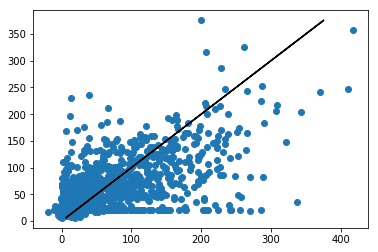

MAE: 31.6
RMSE: 47.3
R^2: 0.45


,qb_dropback-1,qb_dropback-2,rush_attempt-1,qb_dropback-3,fanPts-1,incomplete_pass-1,pass_attempt-1,tackled_for_loss-1,rush_attempt-3,fumble-1,fumble-2,incomplete_pass-2,qb_hit-2,incomplete_pass-3,complete_pass-2,qb_hit-1,no_huddle-1,tackled_for_loss-2,complete_pass-3,tackled_for_loss-3,yards_gained-1,shotgun-3,fanPts-2,rush_yards-1,fumble-3,pass_touchdown-3,pass_attempt-3,interception-1,no_huddle-3,rush_attempt-2,touchdown-2,shotgun-1,rush_touchdown-3,rec_yards-2,yards_gained-3,touchdown-3,yards_gained-2,interception-2,pass_attempt-2,rush_yards-3,yards_after_catch-1,fanPts-3,complete_pass-1,shotgun-2,rush_touchdown-2,yards_after_catch-2,yards_after_catch-3,no_huddle-2,touchdown-1,rec_yards-3,air_yards-3,rec_yards-1,rush_touchdown-1,pass_touchdown-2,rush_yards-2,air_yards-2,pass_touchdown-1,air_yards-1,interception-3,qb_hit-3
1,-0.288,-0.270,-0.233,-0.196,0.194,0.187,0.152,0.135,-0.130,-0.114,-0.109,-0.098,-0.092,0.085,0.081,-0.079,-0.068,0.063,-0.060,0.058,0.058,-0.057,0.056,0.052,-0.049,0.042,0.037,-0.032,0.030,-0.029,-0.027,0.026,-0.025,0.021,0.020,-0.019,0.019,0.018,-0.017,0.016,-0.015,-0.015,0.014,0.011,0.010,0.008,0.008,-0.007,-0.006,0.006,-0.006,0.005,0.005,-0.005,-0.005,0.004,0.004,0.003,0.003,0.002


In [6]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

params = {
    'alpha':[10**x for x in range(-4,6)],
    'normalize':[True,False]
}

grid = GridSearchCV(
    linear_model.Ridge(),
    params,
    n_jobs = -1,
    verbose = 7,
    cv = 5
)

grid.fit(X_train,y_train)

print("Best parameters set found on development set:")
print(grid.best_params_)
     
# cvGrid(params)

m = linear_model.Ridge(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

### Lasso Regression

#### Base model

C:\Users\e358021\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


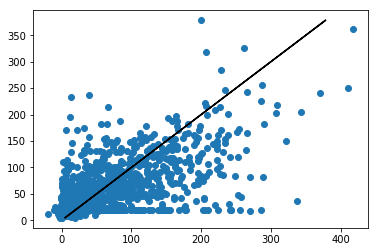

MAE: 31.6
RMSE: 47.3
R^2: 0.45


,qb_dropback-1,incomplete_pass-1,fumble-2,tackled_for_loss-1,rush_attempt-1,pass_attempt-1,qb_dropback-2,qb_dropback-3,fanPts-1,incomplete_pass-2,qb_hit-2,rush_attempt-3,incomplete_pass-3,qb_hit-1,complete_pass-2,yards_gained-1,no_huddle-1,fumble-1,shotgun-3,rush_yards-1,fanPts-2,shotgun-1,yards_gained-2,yards_gained-3,rec_yards-2,rec_yards-1,yards_after_catch-1,rush_yards-2,complete_pass-1,rush_yards-3,rush_attempt-2,shotgun-2,yards_after_catch-2,air_yards-3,air_yards-2,yards_after_catch-3,air_yards-1,touchdown-3,rush_touchdown-1,tackled_for_loss-3,touchdown-1,pass_touchdown-1,interception-1,qb_hit-3,rush_touchdown-3,pass_touchdown-3,no_huddle-2,pass_attempt-2,pass_touchdown-2,rec_yards-3,rush_touchdown-2,tackled_for_loss-2,touchdown-2,fanPts-3,complete_pass-3,fumble-3,interception-3,no_huddle-3,pass_attempt-3,interception-2
1,-0.461,0.328,-0.314,0.300,-0.289,0.260,-0.257,-0.209,0.208,-0.166,-0.144,-0.128,0.120,-0.097,0.079,0.078,-0.070,-0.044,-0.040,0.039,0.036,0.034,0.027,0.024,0.015,-0.015,-0.013,-0.012,0.012,0.010,-0.009,0.007,0.006,-0.005,0.005,0.005,0.002,-0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000


In [7]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

m = linear_model.Lasso()
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.9s finished


Best parameters set found on development set:
{'alpha': 0.01, 'normalize': True}


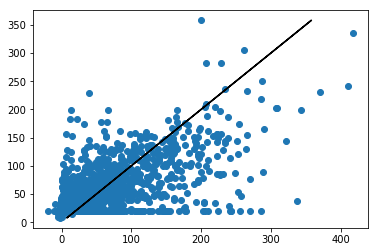

MAE: 31.8
RMSE: 47.4
R^2: 0.45


,fumble-2,fumble-1,fanPts-1,fumble-3,fanPts-2,yards_gained-1,yards_gained-2,rec_yards-2,air_yards-1,no_huddle-2,interception-2,incomplete_pass-2,complete_pass-2,rush_yards-1,rec_yards-1,yards_after_catch-1,touchdown-1,pass_touchdown-2,tackled_for_loss-1,shotgun-1,rush_touchdown-1,rush_attempt-1,qb_hit-1,qb_dropback-1,pass_touchdown-1,pass_attempt-1,no_huddle-1,interception-1,incomplete_pass-1,complete_pass-1,pass_attempt-2,rush_yards-3,qb_dropback-2,rec_yards-3,yards_gained-3,yards_after_catch-3,air_yards-3,touchdown-3,tackled_for_loss-3,shotgun-3,rush_touchdown-3,rush_attempt-3,qb_hit-3,qb_dropback-3,pass_touchdown-3,pass_attempt-3,no_huddle-3,interception-3,incomplete_pass-3,complete_pass-3,fanPts-3,rush_yards-2,yards_after_catch-2,air_yards-2,touchdown-2,tackled_for_loss-2,shotgun-2,rush_touchdown-2,rush_attempt-2,qb_hit-2
1,-0.992,-0.738,0.222,-0.099,0.056,0.052,0.008,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000


In [8]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

params = {
    'alpha':[10**x for x in range(-4,6)],
    'normalize':[True,False]
}

grid = GridSearchCV(
    linear_model.Lasso(),
    params,
    n_jobs = -1,
    verbose = 7,
    cv = 5
)

grid.fit(X_train,y_train)

print("Best parameters set found on development set:")
print(grid.best_params_)
     
# cvGrid(params)

m = linear_model.Lasso(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV, standardized

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.3s finished


Best parameters set found on development set:
{'alpha': 0.01, 'normalize': True}


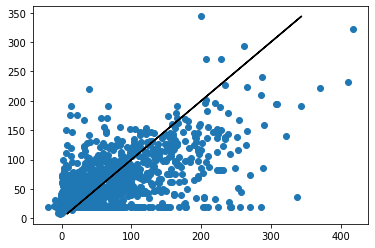

MAE: 31.8
RMSE: 47.4
R^2: 0.45


,yards_gained-1,fanPts-1,yards_gained-2,fanPts-2,fumble-2,fumble-1,rec_yards-2,fumble-3,air_yards-1,no_huddle-2,interception-2,incomplete_pass-2,complete_pass-2,rush_yards-1,rec_yards-1,yards_after_catch-1,touchdown-1,pass_touchdown-2,tackled_for_loss-1,shotgun-1,rush_touchdown-1,rush_attempt-1,qb_hit-1,qb_dropback-1,pass_touchdown-1,pass_attempt-1,no_huddle-1,interception-1,incomplete_pass-1,complete_pass-1,pass_attempt-2,rush_yards-3,qb_dropback-2,rec_yards-3,yards_gained-3,yards_after_catch-3,air_yards-3,touchdown-3,tackled_for_loss-3,shotgun-3,rush_touchdown-3,rush_attempt-3,qb_hit-3,qb_dropback-3,pass_touchdown-3,pass_attempt-3,no_huddle-3,interception-3,incomplete_pass-3,complete_pass-3,fanPts-3,rush_yards-2,yards_after_catch-2,air_yards-2,touchdown-2,tackled_for_loss-2,shotgun-2,rush_touchdown-2,rush_attempt-2,qb_hit-2
1,23.308,13.680,3.669,3.393,-1.263,-0.979,0.221,-0.118,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000


In [5]:
X_train, X_dev, y_train, y_dev = X_train_std, X_dev_std, y_train, y_dev

params = {
    'alpha':[10**x for x in range(-4,6)],
    'normalize':[True,False]
}

grid = GridSearchCV(
    linear_model.Lasso(),
    params,
    n_jobs = -1,
    verbose = 7,
    cv = 5
)

grid.fit(X_train,y_train)

print("Best parameters set found on development set:")
print(grid.best_params_)
     
# cvGrid(params)

m = linear_model.Lasso(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV, standardized, hand-selected features

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
C:\Users\mrkawa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3019326.395688002, tolerance: 3037.9150681688084
  positive)


Best parameters set found on development set:
{'alpha': 0.0001, 'normalize': True}


C:\Users\mrkawa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3019326.395688002, tolerance: 3037.9150681688084
  positive)


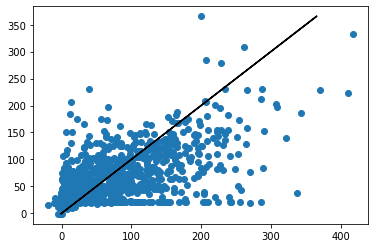

MAE: 31.6
RMSE: 47.4
R^2: 0.45


,fanPts-1,fanPts-2,yards_gained-2,fanPts-3,touchdown-1,touchdown-2,touchdown-3,complete_pass-3,complete_pass-1,yards_gained-3,rush_attempt-1,rush_attempt-3,rush_attempt-2,complete_pass-2,yards_gained-1
1,60.167,44.323,-20.628,18.938,-16.024,-13.899,-7.167,-7.153,-6.085,-4.066,-3.397,-3.339,-2.099,-2.086,-1.326


In [6]:
X_train, X_dev, y_train, y_dev = X_train_std_select, X_dev_std_select, y_train, y_dev

params = {
    'alpha':[10**x for x in range(-4,6)],
    'normalize':[True,False]
}

grid = GridSearchCV(
    linear_model.Lasso(),
    params,
    n_jobs = -1,
    verbose = 7,
    cv = 5
)

grid.fit(X_train,y_train)

print("Best parameters set found on development set:")
print(grid.best_params_)
     
# cvGrid(params)

m = linear_model.Lasso(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV, hand-selected features

### Elastic Net Regression

#### Base model

C:\Users\mrkawa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45575.09840982035, tolerance: 3037.9150681688084
  positive)


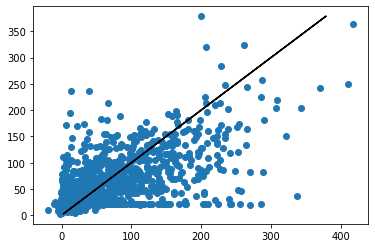

MAE: 31.6
RMSE: 47.3
R^2: 0.45


,fumble-2,qb_dropback-1,incomplete_pass-1,tackled_for_loss-1,fumble-1,qb_hit-2,rush_attempt-1,qb_hit-1,qb_dropback-2,incomplete_pass-2,qb_dropback-3,fanPts-1,incomplete_pass-3,pass_attempt-1,rush_attempt-3,complete_pass-1,complete_pass-2,no_huddle-1,yards_gained-1,pass_touchdown-3,shotgun-3,shotgun-1,complete_pass-3,fanPts-2,rush_yards-1,yards_gained-3,yards_gained-2,rec_yards-1,fanPts-3,rush_yards-2,yards_after_catch-1,shotgun-2,rec_yards-2,no_huddle-3,tackled_for_loss-3,rush_yards-3,yards_after_catch-3,rush_attempt-2,yards_after_catch-2,air_yards-2,air_yards-3,air_yards-1,rec_yards-3,tackled_for_loss-2,pass_touchdown-1,pass_touchdown-2,pass_attempt-2,no_huddle-2,interception-1,interception-3,fumble-3,interception-2,rush_touchdown-2,touchdown-3,pass_attempt-3,rush_touchdown-1,rush_touchdown-3,touchdown-2,qb_hit-3,touchdown-1
1,-0.509,-0.460,0.436,0.357,-0.321,-0.298,-0.298,-0.242,-0.232,-0.224,-0.216,0.207,0.172,0.165,-0.133,0.121,0.095,-0.089,0.080,0.068,-0.047,0.041,-0.040,0.039,0.038,0.028,0.028,-0.019,-0.017,-0.014,-0.013,0.012,0.012,0.011,0.011,0.010,0.007,-0.007,0.006,0.006,-0.006,0.003,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,-0.000,0.000,-0.000


In [12]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

m = linear_model.ElasticNet()
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.5s finished


Best parameters set found on development set:
{'alpha': 10, 'normalize': False}


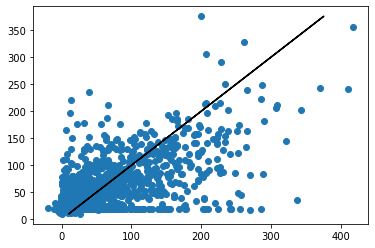

MAE: 31.6
RMSE: 47.3
R^2: 0.45


,qb_dropback-2,fanPts-1,rush_attempt-1,qb_dropback-3,qb_dropback-1,rush_attempt-3,yards_gained-1,rush_yards-1,rec_yards-2,incomplete_pass-1,shotgun-3,yards_gained-3,yards_gained-2,yards_after_catch-1,yards_after_catch-2,pass_attempt-1,fanPts-2,air_yards-3,rush_yards-2,air_yards-1,air_yards-2,yards_after_catch-3,rec_yards-1,touchdown-1,complete_pass-2,rush_touchdown-1,tackled_for_loss-1,shotgun-1,incomplete_pass-2,qb_hit-1,pass_touchdown-1,no_huddle-1,interception-1,fumble-1,complete_pass-1,fumble-2,rush_yards-3,interception-2,fumble-3,touchdown-3,tackled_for_loss-3,rush_touchdown-3,qb_hit-3,pass_touchdown-3,pass_attempt-3,no_huddle-3,interception-3,incomplete_pass-3,complete_pass-3,no_huddle-2,fanPts-3,touchdown-2,tackled_for_loss-2,shotgun-2,rush_touchdown-2,rush_attempt-2,rec_yards-3,pass_touchdown-2,pass_attempt-2,qb_hit-2
1,-0.289,0.175,-0.172,-0.144,-0.090,-0.074,0.067,0.033,0.031,0.030,-0.025,0.021,0.019,-0.013,0.009,0.007,0.005,-0.004,-0.003,0.003,0.002,0.002,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,-0.000


In [13]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

params = {
    'alpha':[10**x for x in range(-4,6)],
    'normalize':[True,False]
}

grid = GridSearchCV(
    linear_model.ElasticNet(),
    params,
    n_jobs = -1,
    verbose = 7,
    cv = 5
)

grid.fit(X_train,y_train)

print("Best parameters set found on development set:")
print(grid.best_params_)
     
# cvGrid(params)

m = linear_model.ElasticNet(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV, standardized

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.8s finished
C:\Users\mrkawa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3066.112580532208, tolerance: 3037.9150681688084
  positive)


Best parameters set found on development set:
{'alpha': 0.01, 'normalize': False}


C:\Users\mrkawa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1097648.7745782826, tolerance: 3037.9150681688084
  positive)


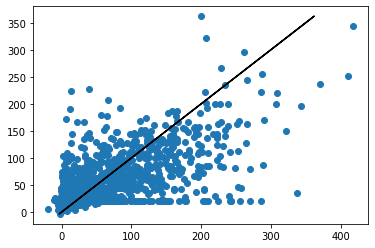

MAE: 31.6
RMSE: 47.2
R^2: 0.45


,yards_gained-1,touchdown-3,rush_attempt-1,qb_dropback-1,rush_yards-1,pass_touchdown-3,fanPts-1,touchdown-2,rush_touchdown-3,incomplete_pass-1,pass_touchdown-2,yards_gained-3,rush_touchdown-2,rec_yards-2,qb_dropback-3,rush_attempt-3,complete_pass-1,yards_gained-2,incomplete_pass-2,rush_yards-3,qb_dropback-2,tackled_for_loss-1,air_yards-2,incomplete_pass-3,air_yards-3,qb_hit-2,fumble-2,yards_after_catch-1,shotgun-1,qb_hit-1,complete_pass-3,shotgun-3,air_yards-1,yards_after_catch-2,interception-3,fumble-1,interception-2,no_huddle-1,touchdown-1,yards_after_catch-3,tackled_for_loss-3,interception-1,qb_hit-3,complete_pass-2,rush_touchdown-1,shotgun-2,no_huddle-3,tackled_for_loss-2,pass_touchdown-1,no_huddle-2,pass_attempt-1,rush_yards-2,rec_yards-1,fanPts-3,fanPts-2,pass_attempt-2,rec_yards-3,rush_attempt-2,fumble-3,pass_attempt-3
1,26.569,-18.279,-18.272,-17.844,14.904,14.354,13.376,-11.926,10.255,9.674,8.876,8.825,8.657,8.416,-8.239,-7.082,7.025,6.332,-6.006,4.046,-4.013,2.890,2.806,2.737,-2.253,-1.798,-1.645,-1.505,1.492,-1.423,-1.377,-1.301,1.281,1.078,1.068,-1.052,0.951,-0.835,-0.824,0.815,0.735,-0.548,0.536,0.476,0.446,0.319,0.287,0.245,0.230,-0.083,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000


In [14]:
X_train, X_dev, y_train, y_dev = X_train_std, X_dev_std, y_train, y_dev

params = {
    'alpha':[10**x for x in range(-4,6)],
    'normalize':[True,False]
}

grid = GridSearchCV(
    linear_model.ElasticNet(),
    params,
    n_jobs = -1,
    verbose = 7,
    cv = 5
)

grid.fit(X_train,y_train)

print("Best parameters set found on development set:")
print(grid.best_params_)
     
# cvGrid(params)

m = linear_model.Lasso(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### Automatic CV, standardized

Alpha: 0.1826602344298149
l1 ratio: 0.75


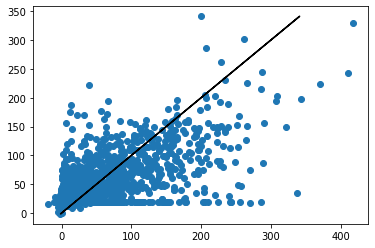

MAE: 31.7
RMSE: 47.2
R^2: 0.45


,yards_gained-1,fanPts-1,rush_yards-1,rec_yards-1,yards_gained-2,rec_yards-2,incomplete_pass-1,fanPts-2,fumble-2,fumble-1,incomplete_pass-2,tackled_for_loss-1,qb_dropback-3,yards_gained-3,touchdown-1,qb_hit-2,air_yards-1,air_yards-2,rush_touchdown-1,fumble-3,pass_attempt-1,pass_touchdown-1,qb_dropback-2,yards_after_catch-2,qb_hit-1,shotgun-3,tackled_for_loss-2,pass_touchdown-3,pass_touchdown-2,no_huddle-1,rec_yards-3,complete_pass-1,rush_yards-3,rush_yards-2,shotgun-1,air_yards-3,tackled_for_loss-3,yards_after_catch-1,rush_attempt-1,interception-1,touchdown-3,yards_after_catch-3,qb_dropback-1,incomplete_pass-3,rush_touchdown-3,rush_attempt-3,qb_hit-3,pass_attempt-3,interception-2,no_huddle-2,pass_attempt-2,rush_attempt-2,rush_touchdown-2,shotgun-2,touchdown-2,no_huddle-3,interception-3,fanPts-3,complete_pass-3,complete_pass-2
1,11.054,8.754,7.852,7.112,3.754,3.575,2.547,2.442,-2.099,-1.882,-1.869,1.759,-1.625,1.388,1.336,-1.214,1.134,1.001,0.978,-0.978,0.925,0.923,-0.901,0.880,-0.872,-0.779,0.777,0.679,0.505,-0.470,0.382,0.379,0.360,0.233,0.134,-0.099,0.021,-0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000


In [8]:
X_train, X_dev, y_train, y_dev = X_train_std, X_dev_std, y_train, y_dev

m = linear_model.ElasticNetCV(l1_ratio=[.25,.5,.75], random_state=0)
m.fit(X_train,y_train)
print(f'Alpha: {m.alpha_}')
print(f'l1 ratio: {m.l1_ratio_}')

y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV, standardized, hand-selected features

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    3.5s finished
C:\Users\mrkawa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7980511.336908929, tolerance: 3037.9150681688084
  positive)


Best parameters set found on development set:
{'alpha': 0.0001, 'l1_ratio': 0.5, 'normalize': False}


C:\Users\mrkawa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7980511.336908929, tolerance: 3037.9150681688084
  positive)


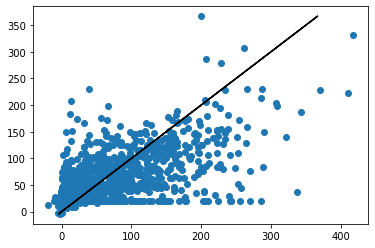

MAE: 31.7
RMSE: 47.4
R^2: 0.45


,fanPts-1,fanPts-2,fanPts-3,yards_gained-2,touchdown-1,touchdown-2,touchdown-3,yards_gained-3,complete_pass-3,complete_pass-1,yards_gained-1,rush_attempt-1,rush_attempt-3,complete_pass-2,rush_attempt-2
1,64.428,52.656,27.011,-26.578,-17.442,-16.584,-9.740,-9.621,-7.310,-6.297,-4.107,-3.450,-3.304,-2.071,-1.935


In [9]:
X_train, X_dev, y_train, y_dev = X_train_std_select, X_dev_std_select, y_train, y_dev

params = {
    'alpha':[10**x for x in range(-4,6)],
    'normalize':[True,False],
    'l1_ratio':[.25,.5,.75]
}

grid = GridSearchCV(
    linear_model.ElasticNet(),
    params,
    n_jobs = -1,
    verbose = 7,
    cv = 5
)

grid.fit(X_train,y_train)

print("Best parameters set found on development set:")
print(grid.best_params_)
     
# cvGrid(params)

m = linear_model.ElasticNet(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### Automatic CV, standardized, hand-selected features

Alpha: 0.05578179631582934
l1 ratio: 0.75


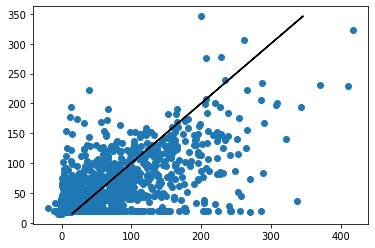

MAE: 31.7
RMSE: 47.4
R^2: 0.45


,yards_gained-1,fanPts-1,fanPts-2,complete_pass-3,yards_gained-2,fanPts-3,yards_gained-3,rush_attempt-2,rush_attempt-3,touchdown-3,touchdown-2,complete_pass-2,touchdown-1,rush_attempt-1,complete_pass-1
1,19.335,17.855,7.031,-4.373,4.295,3.806,2.723,-2.183,-2.037,-1.848,-1.402,-1.173,-0.604,-0.078,-0.000


In [10]:
X_train, X_dev, y_train, y_dev = X_train_std_select, X_dev_std_select, y_train, y_dev

m = linear_model.ElasticNetCV(l1_ratio=[.25,.5,.75], random_state=0)
m.fit(X_train,y_train)
print(f'Alpha: {m.alpha_}')
print(f'l1 ratio: {m.l1_ratio_}')

y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV, standardized, hand-selected features, force positive coefficients

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    3.8s finished


Best parameters set found on development set:
{'alpha': 0.01, 'l1_ratio': 0.25, 'normalize': False, 'positive': True}


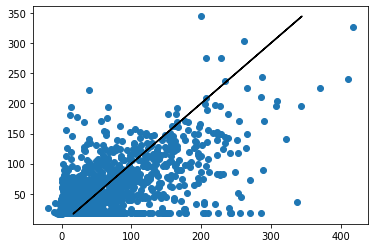

MAE: 31.8
RMSE: 47.5
R^2: 0.45


,yards_gained-1,fanPts-1,fanPts-2,yards_gained-2,complete_pass-2,complete_pass-1,yards_gained-3,touchdown-3,rush_attempt-3,complete_pass-3,fanPts-3,touchdown-2,rush_attempt-2,touchdown-1,rush_attempt-1
1,20.260,16.489,4.518,2.320,0.430,0.041,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [11]:
X_train, X_dev, y_train, y_dev = X_train_std_select, X_dev_std_select, y_train, y_dev

params = {
    'alpha':[10**x for x in range(-4,6)],
    'normalize':[True,False],
    'l1_ratio':[.25,.5,.75],
    'positive':[True]
}

grid = GridSearchCV(
    linear_model.ElasticNet(),
    params,
    n_jobs = -1,
    verbose = 7,
    cv = 5
)

grid.fit(X_train,y_train)

print("Best parameters set found on development set:")
print(grid.best_params_)
     
# cvGrid(params)

m = linear_model.ElasticNet(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### Automatic CV, standardized, hand-selected features, force positive coefficients

Alpha: 123.30285553509971
l1 ratio: 0.75


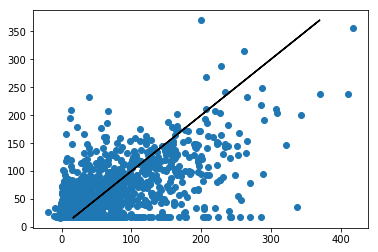

MAE: 31.8
RMSE: 47.6
R^2: 0.44


,yards_gained-1,yards_gained-2,yards_gained-3,touchdown-3,rush_attempt-3,complete_pass-3,fanPts-3,touchdown-2,rush_attempt-2,complete_pass-2,fanPts-2,touchdown-1,rush_attempt-1,complete_pass-1,fanPts-1
1,0.083,0.016,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [20]:
X_train, X_dev, y_train, y_dev = X_train_std_select, X_dev_std_select, y_train, y_dev

m = linear_model.ElasticNetCV(l1_ratio=[.25,.5,.75], positive=[True], random_state=0)
m.fit(X_train,y_train)
print(f'Alpha: {m.alpha_}')
print(f'l1 ratio: {m.l1_ratio_}')

y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

### Bayesian Ridge Regression

#### Base model

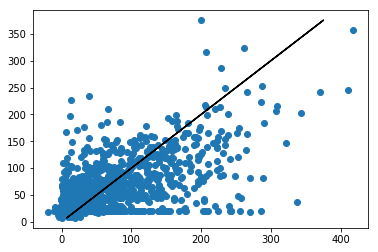

MAE: 31.6
RMSE: 47.3
R^2: 0.45


,qb_dropback-2,qb_dropback-1,rush_attempt-1,fanPts-1,qb_dropback-3,incomplete_pass-1,pass_attempt-1,rush_attempt-3,tackled_for_loss-1,fumble-1,fumble-2,incomplete_pass-2,incomplete_pass-3,qb_hit-2,no_huddle-1,complete_pass-2,yards_gained-1,qb_hit-1,shotgun-3,tackled_for_loss-2,fanPts-2,rush_yards-1,complete_pass-3,tackled_for_loss-3,fumble-3,rush_attempt-2,pass_touchdown-3,no_huddle-3,pass_attempt-3,pass_attempt-2,interception-1,shotgun-1,rec_yards-2,yards_gained-3,rush_touchdown-3,touchdown-2,yards_gained-2,touchdown-3,yards_after_catch-1,rush_yards-3,fanPts-3,interception-2,yards_after_catch-2,complete_pass-1,yards_after_catch-3,rec_yards-1,rec_yards-3,shotgun-2,pass_touchdown-1,rush_touchdown-2,air_yards-3,rush_touchdown-1,no_huddle-2,rush_yards-2,air_yards-2,air_yards-1,pass_touchdown-2,interception-3,qb_hit-3,touchdown-1
1,-0.253,-0.244,-0.214,0.185,-0.182,0.149,0.124,-0.120,0.101,-0.088,-0.083,-0.081,0.066,-0.066,-0.059,0.058,0.057,-0.056,-0.056,0.054,0.054,0.050,-0.049,0.047,-0.040,-0.029,0.028,0.027,0.026,-0.023,-0.022,0.021,0.021,0.019,-0.019,-0.019,0.019,-0.016,-0.015,0.014,-0.012,0.012,0.009,0.008,0.007,0.007,0.006,0.006,0.006,0.006,-0.005,0.005,-0.005,-0.004,0.003,0.003,-0.003,0.002,0.001,0.000


In [21]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

m = linear_model.BayesianRidge()
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV

Fitting 3 folds for each of 1250 candidates, totalling 3750 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 453 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 693 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 965 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 1269 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 1605 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 1973 tasks      | elapsed:   53.4s
[Parallel(n_jobs=-1)]: Done 2373 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2805 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3269 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3743 out of 3750 | elapsed:  1.6min remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3750 out of 375

Best parameters set found on development set:
{'alpha_1': 0.01, 'alpha_2': 100, 'lambda_1': 100, 'lambda_2': 1, 'normalize': False}


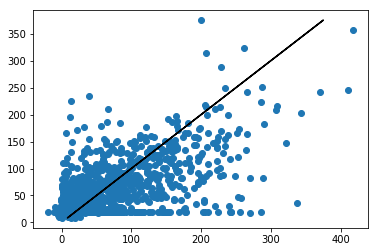

MAE: 31.6
RMSE: 47.3
R^2: 0.45


,qb_dropback-2,qb_dropback-1,rush_attempt-1,fanPts-1,qb_dropback-3,incomplete_pass-1,rush_attempt-3,pass_attempt-1,tackled_for_loss-1,fumble-1,incomplete_pass-2,fumble-2,yards_gained-1,shotgun-3,incomplete_pass-3,fanPts-2,no_huddle-1,qb_hit-2,rush_yards-1,tackled_for_loss-2,qb_hit-1,complete_pass-2,complete_pass-3,tackled_for_loss-3,fumble-3,rush_attempt-2,pass_attempt-2,no_huddle-3,rec_yards-2,pass_touchdown-3,yards_gained-2,yards_gained-3,shotgun-1,pass_attempt-3,interception-1,yards_after_catch-1,rush_touchdown-3,touchdown-2,touchdown-3,rush_yards-3,yards_after_catch-2,fanPts-3,rec_yards-1,interception-2,yards_after_catch-3,pass_touchdown-1,rec_yards-3,air_yards-3,rush_touchdown-1,touchdown-1,rush_yards-2,rush_touchdown-2,complete_pass-1,no_huddle-2,air_yards-2,air_yards-1,shotgun-2,pass_touchdown-2,interception-3,qb_hit-3
1,-0.236,-0.213,-0.198,0.176,-0.168,0.124,-0.112,0.103,0.080,-0.073,-0.071,-0.067,0.057,-0.054,0.053,0.052,-0.052,-0.051,0.048,0.047,-0.043,0.043,-0.042,0.039,-0.035,-0.029,-0.029,0.024,0.021,0.020,0.019,0.018,0.018,0.017,-0.016,-0.015,-0.015,-0.014,-0.013,0.013,0.010,-0.010,0.009,0.009,0.007,0.007,0.006,-0.005,0.005,0.004,-0.004,0.004,0.004,-0.003,0.003,0.003,0.002,-0.001,0.001,0.001


In [22]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

params = {
    'alpha_1':[10**x for x in range(-2,3)],
    'alpha_2':[10**x for x in range(-2,3)],
    'lambda_1':[10**x for x in range(-2,3)],
    'lambda_2':[10**x for x in range(-2,3)],
    'normalize':[True,False]
}

grid = GridSearchCV(
    linear_model.BayesianRidge(),
    params,
    n_jobs = -1,
    verbose = 7,
    cv = 3
)

grid.fit(X_train,y_train)

print("Best parameters set found on development set:")
print(grid.best_params_)
     
# cvGrid(params)

m = linear_model.BayesianRidge(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV, standardized

Fitting 3 folds for each of 1250 candidates, totalling 3750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 1336 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapse

Best parameters set found on development set:
{'alpha_1': 0.01, 'alpha_2': 100, 'lambda_1': 10, 'lambda_2': 100, 'normalize': False}


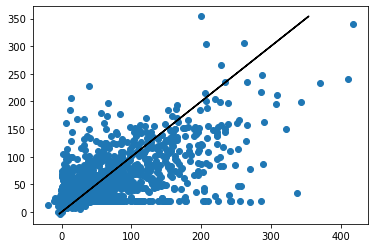

MAE: 31.6
RMSE: 47.2
R^2: 0.45


,yards_gained-1,rush_yards-1,fanPts-1,rec_yards-1,rec_yards-2,rush_attempt-1,qb_dropback-1,yards_gained-2,touchdown-3,qb_dropback-2,qb_dropback-3,rush_attempt-3,incomplete_pass-1,pass_touchdown-3,incomplete_pass-2,yards_gained-3,touchdown-2,rush_yards-3,fanPts-2,rec_yards-3,air_yards-2,pass_touchdown-2,rush_touchdown-2,complete_pass-3,air_yards-3,fumble-2,fumble-1,qb_hit-2,rush_attempt-2,tackled_for_loss-1,rush_touchdown-3,pass_attempt-1,incomplete_pass-3,air_yards-1,shotgun-3,qb_hit-1,complete_pass-2,fanPts-3,yards_after_catch-2,rush_touchdown-1,yards_after_catch-1,pass_touchdown-1,tackled_for_loss-2,shotgun-1,pass_attempt-2,no_huddle-1,tackled_for_loss-3,interception-1,yards_after_catch-3,rush_yards-2,pass_attempt-3,complete_pass-1,interception-2,fumble-3,qb_hit-3,shotgun-2,no_huddle-3,interception-3,touchdown-1,no_huddle-2
1,13.968,12.608,10.068,8.564,6.403,-6.075,-5.346,5.216,-4.757,-4.737,-4.583,-4.387,4.380,4.092,-3.870,3.867,-3.431,3.335,2.717,2.700,2.454,2.402,2.392,-2.358,-1.941,-1.930,-1.898,-1.876,-1.716,1.705,1.671,1.615,1.565,1.518,-1.490,-1.459,1.454,1.297,1.283,1.234,-1.081,1.024,1.020,0.959,-0.937,-0.827,0.820,-0.805,0.797,0.788,-0.668,0.613,0.605,-0.542,0.412,0.390,0.231,0.228,-0.184,-0.095


In [20]:
X_train, X_dev, y_train, y_dev = X_train_std, X_dev_std, y_train, y_dev

params = {
    'alpha_1':[10**x for x in range(-2,3)],
    'alpha_2':[10**x for x in range(-2,3)],
    'lambda_1':[10**x for x in range(-2,3)],
    'lambda_2':[10**x for x in range(-2,3)],
    'normalize':[True,False]
}

grid = GridSearchCV(
    linear_model.BayesianRidge(),
    params,
    n_jobs = -1,
    verbose = 7,
    cv = 3
)

grid.fit(X_train,y_train)

print("Best parameters set found on development set:")
print(grid.best_params_)
     
# cvGrid(params)

m = linear_model.BayesianRidge(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV, standardized, hand-selected features

Fitting 5 folds for each of 1250 candidates, totalling 6250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 1008 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 1424 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 1904 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 3728 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 4464 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 5264 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 6128 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 6250 out of 6250 | elapsed:   39.1s finished


Best parameters set found on development set:
{'alpha_1': 100, 'alpha_2': 0.01, 'lambda_1': 0.01, 'lambda_2': 100, 'normalize': False}


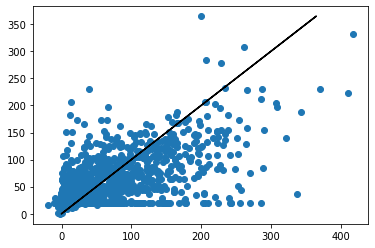

MAE: 31.6
RMSE: 47.4
R^2: 0.45


,fanPts-1,fanPts-2,fanPts-3,yards_gained-2,touchdown-2,touchdown-1,touchdown-3,yards_gained-3,complete_pass-3,complete_pass-1,yards_gained-1,rush_attempt-1,rush_attempt-3,rush_attempt-2,complete_pass-2
1,51.740,42.369,24.086,-19.305,-13.237,-13.210,-8.829,-7.769,-7.120,-6.030,4.522,-3.522,-3.234,-2.095,-2.044


In [21]:
X_train, X_dev, y_train, y_dev = X_train_std_select, X_dev_std_select, y_train, y_dev

params = {
    'alpha_1':[10**x for x in range(-2,3)],
    'alpha_2':[10**x for x in range(-2,3)],
    'lambda_1':[10**x for x in range(-2,3)],
    'lambda_2':[10**x for x in range(-2,3)],
    'normalize':[True,False]
}

grid = GridSearchCV(
    linear_model.BayesianRidge(),
    params,
    n_jobs = -1,
    verbose = 7,
    cv = 5
)

grid.fit(X_train,y_train)

print("Best parameters set found on development set:")
print(grid.best_params_)
     
# cvGrid(params)

m = linear_model.BayesianRidge(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV, hand-selected features, force positive coefficients

In [22]:
# X_train, X_dev, y_train, y_dev = X_train_select, X_dev_select, y_train, y_dev

# params = {
#     'alpha_1':[10**x for x in range(-4,10)],
#     'alpha_2':[10**x for x in range(-4,10)],
#     'lambda_1':[10**x for x in range(-4,10)],
#     'lambda_2':[10**x for x in range(-4,10)],
#     'normalize':[True,False],
#     'positive':[True]
# }

# grid = GridSearchCV(
#     linear_model.BayesianRidge(),
#     params,
#     n_jobs = -1,
#     verbose = 7,
#     cv = 5
# )

# grid.fit(X_train,y_train)

# print("Best parameters set found on development set:")
# print(grid.best_params_)
     
# # cvGrid(params)

# clf = linear_model.BayesianRidge(**grid.best_params_)
# clf.fit(X_train,y_train)
# y_pred = clf.predict(X_dev)

# printStats(y_dev, y_pred)

# coefs = pd.DataFrame([X_train.columns,clf.coef_]).transpose()
# coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
# coefs